<a href="https://colab.research.google.com/github/JangAyeon/ToBigs/blob/master/%5B7%5DNeuralNetworkAdvanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import torch 
from torch import nn
from torchvision import datasets,transforms
import torch.nn.functional as F

from prettytable import PrettyTable

from tqdm import tqdm

#**Load Data**

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv("sample_submission.csv")

In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data=test_data.iloc[:,1:] #0번 column에 필요없는 index자료 제거
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = train_data.drop('label',axis = 1).values #train data의 label값을 제거
y_train = train_data['label'].values #label값 할당
X_test = test_data.values

## **1.train / test data 크기**

In [6]:
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (18000, 784))

## **2.그림 출력**

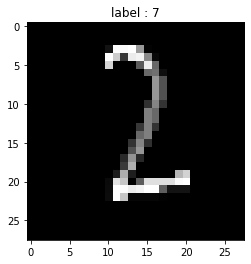

In [7]:
#그림 출력

index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

##**3.그림 사이즈 파악**

In [8]:
 #전체 784 pixel, 즉, 28*28 사이즈의 그림들임!

image_size = X_train.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


##**3.Scaling**

In [9]:
# scaling

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print('maximum value after scaling:', X_train.max(),
      '\nminimum value after scaling:' ,X_train.min())

maximum value after scaling: 1.0 
minimum value after scaling: 0.0


## **4. train / test data split & size**

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(33600, 784) (33600,)
(8400, 784) (8400,)


##**5.numpy -> tensor**

In [11]:

X_train = torch.Tensor(list(X_train))
X_val = torch.Tensor(list(X_val))
y_train = torch.Tensor(list(y_train))
y_val = torch.Tensor(list(y_val))
X_test = torch.Tensor(list(X_test))

##**6.함수**

###**NN의 Parameters 갯수 표**

In [12]:

def count_parameters(model):
  table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel()
    table.add_row([name, param])
    total_params+=param
  print(table)
  print('Total Trainable Params: {}'.format(total_params))
  return total_params

###**CNN : loss & accuracy in train**

In [13]:


def get_result(epochs):
  running_loss_history = []
  running_corrects_history = []
  validation_running_loss_history = []
  validation_running_corrects_history = []

  t0 = int(round(time.time()))
  for eno in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0
    validation_running_loss = 0.0
    validation_running_corrects = 0.0

   # a batch of 100 images x 600 batches -> 60,000 for a single epoch 
    for inputs, labels in train_loader:     
    # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
    ## inputs = inputs.view(inputs.shape[0], -1) # [100, 784]
      inputs, labels = inputs.to(device),labels.to(device,dtype=torch.long)
      outputs = model(inputs) # logits (scores)
      loss = criterion(outputs, labels) # outputs [100, 1], labels [100]
    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #max function output(max, max_indices)
      _, pred_idx = torch.max(outputs, 1) # 2nd argument - the dim to reduce    

      running_loss += loss.item() # loss per batch 
      running_corrects += torch.sum(pred_idx == labels.data)
    else:
      with torch.no_grad():
        model.eval()
        for validation_inputs, validation_labels in validation_loader:     
        # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
        ## validation_inputs = validation_inputs.view(validation_inputs.shape[0], -1) # [100, 784]
          validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device,dtype=torch.long)
          validation_outputs = model(validation_inputs) # logits (scores)
          validation_loss = criterion(validation_outputs, validation_labels) # outputs [100, 1], labels [100]
        
        #max function output(max, max_indices)
          _, pred_idx = torch.max(validation_outputs, 1) # 2nd argument - the dim to reduce    

          validation_running_loss += validation_loss.item() # loss per batch 
          validation_running_corrects += torch.sum(pred_idx == validation_labels.data)

      epoch_loss = running_loss/len(train_loader) 
      running_loss_history.append(epoch_loss)
      epoch_acc = (running_corrects.float()/inputs.shape[0]*100)/len(train_loader) 
      running_corrects_history.append(epoch_acc)
      print('--------------- epoch: ', (eno+1), '---------------')
      print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))   

      validation_epoch_loss = validation_running_loss/len(validation_loader) 
      validation_running_loss_history.append(validation_epoch_loss)
      validation_epoch_acc = (validation_running_corrects.float()/validation_inputs.shape[0]*100)/len(validation_loader) 
      validation_running_corrects_history.append(validation_epoch_acc)    
      print('validation loss: {:.4f}, accuracy {:.4f}'.format(validation_epoch_loss, validation_epoch_acc.item())) 

  print('\n#Time elapsed : {} seconds\n'.format(int(round(time.time())) - t0))
  plt.subplot(121) #loss를 그래프로 표현
  plt.title('Loss graph', pad=20)
  plt.plot(running_loss_history, label='training loss')
  plt.plot(validation_running_loss_history, label='validation loss')

  plt.subplot(122) #accuracy를 그래프로 표현
  plt.title('Accuracy graph', pad=20)
  plt.plot(running_corrects_history, label='training accuracy(%)')
  plt.plot(validation_running_corrects_history, label='validation accuracy(%)')

###**NN : loss & accuracy in train**

In [14]:
#단순 NN에서 train / validation 과정에서 loss와 accuracy를 보이는 함수

def get_result_linear(epochs):
  
  #training 단계에서 loss를 저장하기 위한
  running_loss_history = []
  running_corrects_history = []

  #validation용으로 loss, 정답률 측정
  validation_running_loss_history = []
  validation_running_corrects_history = []

  t0 = int(round(time.time()))
  for eno in range(epochs):

   #initialization 시키기
    running_loss = 0.0
    running_corrects = 0.0
    validation_running_loss = 0.0
    validation_running_corrects = 0.0

  # a batch of 100 images x 600 batches -> 60,000 for a single epoch 
    for inputs, labels in train_loader:     
      
    # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
      inputs = inputs.view(inputs.shape[0], -1) # [100, 784]
      inputs, labels = inputs.to(device),labels.to(device,dtype=torch.long)
      outputs = model(inputs) # logits (scores)
      loss = criterion(outputs, labels) # outputs [100, 1], labels [100]
    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #max function output(max, max_indices)
      _, pred_idx = torch.max(outputs, 1) # 2nd argument - the dim to reduce    

      running_loss += loss.item() # loss per batch 
      running_corrects += torch.sum(pred_idx == labels.data)  

    else: #update된 모델을 이용해서 정확도를 예측해보기
   
      with torch.no_grad():#gradient하지 않고 모델 update하지 않기 위해서
        model.eval()
        for validation_inputs, validation_labels in validation_loader:     
          
        # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
          validation_inputs = validation_inputs.view(validation_inputs.shape[0], -1) # [100, 784]
          validation_inputs, validation_labels = validation_inputs.to(device),validation_labels.to(device,dtype=torch.long)
          validation_outputs = model(validation_inputs) # logits (scores)
          validation_loss = criterion(validation_outputs, validation_labels) # outputs [100, 1], labels [100]
        
        #max function output(max, max_indices)
          _, pred_idx = torch.max(validation_outputs, 1) # 2nd argument - the dim to reduce    

          validation_running_loss += validation_loss.item() # loss per batch 
          validation_running_corrects += torch.sum(pred_idx == validation_labels.data)

    epoch_loss = running_loss/len(train_loader) 
    running_loss_history.append(epoch_loss)
    epoch_acc = (running_corrects.float()/inputs.shape[0]*100)/len(train_loader) 
    running_corrects_history.append(epoch_acc)
    print('--------------- epoch: ', (eno+1), '---------------')
    print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))   

    validation_epoch_loss = validation_running_loss/len(validation_loader) 
    validation_running_loss_history.append(validation_epoch_loss)
    validation_epoch_acc = (validation_running_corrects.float()/validation_inputs.shape[0]*100)/len(validation_loader) 
    validation_running_corrects_history.append(validation_epoch_acc)    
    print('validation loss: {:.4f}, accuracy {:.4f}'.format(validation_epoch_loss, validation_epoch_acc.item())) 


  print('\n#Time elapsed : {} seconds\n'.format(int(round(time.time())) - t0))
  plt.subplot(121)
  plt.title('Loss graph', pad=20)
  plt.plot(running_loss_history, label='training loss')
  plt.plot(validation_running_loss_history, label='validation loss')

  plt.subplot(122)
  plt.title('Accuracy graph', pad=20)
  plt.plot(running_corrects_history, label='training accuracy(%)')
  plt.plot(validation_running_corrects_history, label='validation accuracy(%)')


#**[1] Linear NN**

##**1.Runtime Type**
GPU

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use GPU
print(device)

cuda:0


##**2.Set Train / Validation Data**

In [16]:
batch=100

X_train = X_train.view(-1,1,28,28)
X_val = X_val.view(-1,1,28,28)
X_test = X_test.view(-1,1,28,28)


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch)

validation_dataset = torch.utils.data.TensorDataset(X_val, y_val)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch)

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch)

##**3.Create Neural Network**

In [17]:
class NN_1(nn.Module):
  def __init__(self, NN_in, H1, NN_out):
    #in과 out에 hidden node 갯수 정해주기, 
    #이 모델 자체를 변하게 하는 in-put feature 갯수 & hidden layer에 node 갯수
 
  
    super().__init__()
    self.linear1 = nn.Linear(NN_in, H1)
    self.linear2 = nn.Linear(H1, NN_out)

    #NN_OUT : 10개 숫자가 0에서 9까지
    #NN_IN : 28 곱하기 28의 갯수

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = self.linear2(x) 
    # activation not needed for multi-class classification task
    return x

In [18]:
torch.manual_seed(1)
model = NN_1(784, 500, 10).to(device)
model

NN_1(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=10, bias=True)
)

##**4.Set Optimizer & Loss Function**

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss() # 

##**5.Count Parameters**

In [20]:
count_parameters(model)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| linear1.weight |   392000   |
|  linear1.bias  |    500     |
| linear2.weight |    5000    |
|  linear2.bias  |     10     |
+----------------+------------+
Total Trainable Params: 397510


397510

##**6.Get Train / Validation Accuracy**

--------------- epoch:  1 ---------------
training loss: 0.8891, accuracy 85.3988
validation loss: 0.3082, accuracy 92.8333
--------------- epoch:  2 ---------------
training loss: 0.2433, accuracy 93.9970
validation loss: 0.2066, accuracy 94.5119
--------------- epoch:  3 ---------------
training loss: 0.1859, accuracy 95.0744
validation loss: 0.1753, accuracy 95.0595
--------------- epoch:  4 ---------------
training loss: 0.1619, accuracy 95.7083
validation loss: 0.1590, accuracy 95.2738
--------------- epoch:  5 ---------------
training loss: 0.1475, accuracy 96.0089
validation loss: 0.1483, accuracy 95.6548
--------------- epoch:  6 ---------------
training loss: 0.1373, accuracy 96.2321
validation loss: 0.1406, accuracy 95.8333
--------------- epoch:  7 ---------------
training loss: 0.1295, accuracy 96.4107
validation loss: 0.1345, accuracy 95.9524
--------------- epoch:  8 ---------------
training loss: 0.1231, accuracy 96.5923
validation loss: 0.1295, accuracy 96.1310
--------

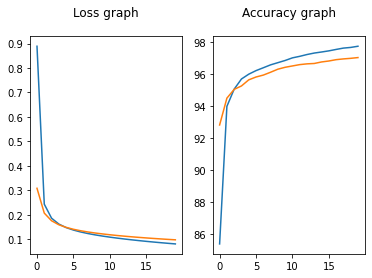

In [21]:
get_result_linear(20)

#**[2] CNN (1)**

##**1.Runtime Type**
 GPU

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use GPU
print(device)

cuda:0


##**2.Set Train / Validation Data**

In [23]:
batch=100

X_train = X_train.view(-1,1,28,28)
X_val = X_val.view(-1,1,28,28)
X_test = X_test.view(-1,1,28,28)


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch)

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch)

##**3.Create Neural Network**

In [24]:
class CNN_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 15, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv2 = nn.Conv2d(in_channels = 15, out_channels = 30, 
                           kernel_size = 3, stride = 1, padding = 0)
    self.fc1 = nn.Linear(5*5*30, 500)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.tanh(self.conv1(x))
    x = F.max_pool2d(x, kernel_size = 2, stride = 2)
    x = F.tanh(self.conv2(x))
    x = F.max_pool2d(x, kernel_size = 2, stride = 2)
    x = x.view(-1, 5*5*30)      # flattening, torch.Size([batch 100, 5*5*30=750])  
    x = F.tanh(self.fc1(x))
    x = self.fc2(x)
    return x

In [25]:
torch.manual_seed(1)
model = CNN_1().to(device)
model

CNN_1(
  (conv1): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=750, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

##**4.Set Optimizer & Loss Function**

In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss() # cf. BCE()

##**5.Count Parameters**

In [26]:
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    375     |
|  conv1.bias  |     15     |
| conv2.weight |    4050    |
|  conv2.bias  |     30     |
|  fc1.weight  |   375000   |
|   fc1.bias   |    500     |
|  fc2.weight  |    5000    |
|   fc2.bias   |     10     |
+--------------+------------+
Total Trainable Params: 384980


384980

##**6.Get Train / Validation Accuracy**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


--------------- epoch:  1 ---------------
training loss: 2.2953, accuracy 10.6250
validation loss: 2.2852, accuracy 12.1429
--------------- epoch:  2 ---------------
training loss: 2.2752, accuracy 16.8780
validation loss: 2.2636, accuracy 25.0119
--------------- epoch:  3 ---------------
training loss: 2.2515, accuracy 39.8958
validation loss: 2.2370, accuracy 57.0476
--------------- epoch:  4 ---------------
training loss: 2.2209, accuracy 67.3839
validation loss: 2.2014, accuracy 77.0833
--------------- epoch:  5 ---------------
training loss: 2.1789, accuracy 78.8185
validation loss: 2.1512, accuracy 82.1190
--------------- epoch:  6 ---------------
training loss: 2.1186, accuracy 82.3929
validation loss: 2.0784, accuracy 84.5000
--------------- epoch:  7 ---------------
training loss: 2.0301, accuracy 84.4583
validation loss: 1.9713, accuracy 86.0000
--------------- epoch:  8 ---------------
training loss: 1.9009, accuracy 85.8274
validation loss: 1.8168, accuracy 86.9405
--------

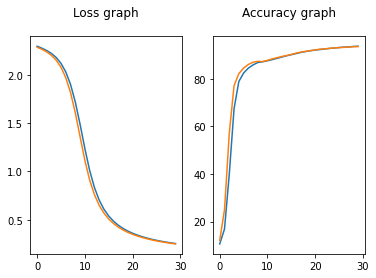

In [28]:
get_result(epochs=30)

#**[3] CNN (2)**

##**1.Runtime Type**
 GPU

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use GPU
print(device)

cuda:0


##**2.Set Train / Validation Data**

In [30]:
batch=100

X_train = X_train.view(-1,1,28,28)
X_val = X_val.view(-1,1,28,28)
X_test = X_test.view(-1,1,28,28)


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch)

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch)

##**3.Create Neural Network**

In [31]:
class CNN_2(nn.Module):

    def __init__(self):
        super().__init__()        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 30, 
                             kernel_size = 5, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = 30, out_channels = 30, 
                             kernel_size = 3, stride = 1, padding = 0)       
        
        self.fc1 = nn.Linear(30*5*5, 500)               
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)

        x = x.view(-1, 30*5*5)    # flattening, torch.Size([100 (batch), 30*5*5])      
        x = F.relu(self.fc1(x))        
        x = self.fc2(x)     # activation not needed    # multi class classification -> raw output instead of softmax applied 
        return x

In [32]:
torch.manual_seed(1)
model = CNN_2().to(device)
model

CNN_2(
  (conv1): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=750, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

##**4.Set Optimizer & Loss Function**

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

##**5.Count Parameters**

In [33]:
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    750     |
|  conv1.bias  |     30     |
| conv2.weight |    8100    |
|  conv2.bias  |     30     |
|  fc1.weight  |   375000   |
|   fc1.bias   |    500     |
|  fc2.weight  |    5000    |
|   fc2.bias   |     10     |
+--------------+------------+
Total Trainable Params: 389420


389420

##**6.Get Train / Validation Accuracy**

In [35]:
#train

epochs = 25
running_loss_history = []
running_corrects_history = []

t0 = int(round(time.time()))
for eno in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0


  # a batch of 100 images x 600 batches -> 60,000 for a single epoch 
  for inputs, labels in train_loader:     
    inputs, labels = inputs.to(device),labels.to(device,dtype=torch.long)
    # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
    ## inputs = inputs.view(inputs.shape[0], -1) # [100, 784]
    outputs = model(inputs) # logits (scores)
    loss = criterion(outputs, labels) # outputs [100, 1], labels [100]
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #max function output(max, max_indices)
    _, pred_idx = torch.max(outputs, 1) # 2nd argument - the dim to reduce    

    running_loss += loss.item() # loss per batch 
    running_corrects += torch.sum(pred_idx == labels.data)


  epoch_loss = running_loss/len(train_loader) 
  running_loss_history.append(epoch_loss)
  epoch_acc = (running_corrects.float()/inputs.shape[0]*100)/len(train_loader) 
  running_corrects_history.append(epoch_acc)
  print('--------------- epoch: ', (eno+1), '---------------')
  print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))   

--------------- epoch:  1 ---------------
training loss: 0.2291, accuracy 93.1042
--------------- epoch:  2 ---------------
training loss: 0.0522, accuracy 98.4405
--------------- epoch:  3 ---------------
training loss: 0.0329, accuracy 99.0060
--------------- epoch:  4 ---------------
training loss: 0.0236, accuracy 99.2827
--------------- epoch:  5 ---------------
training loss: 0.0187, accuracy 99.4524
--------------- epoch:  6 ---------------
training loss: 0.0149, accuracy 99.5327
--------------- epoch:  7 ---------------
training loss: 0.0115, accuracy 99.6071
--------------- epoch:  8 ---------------
training loss: 0.0095, accuracy 99.6964
--------------- epoch:  9 ---------------
training loss: 0.0086, accuracy 99.7619
--------------- epoch:  10 ---------------
training loss: 0.0079, accuracy 99.7560
--------------- epoch:  11 ---------------
training loss: 0.0058, accuracy 99.8214
--------------- epoch:  12 ---------------
training loss: 0.0054, accuracy 99.8244
-------------

In [36]:
#test
model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.

validation_running_loss_history = []
validation_running_corrects_history = []

validation_running_loss = 0.0
validation_running_corrects = 0.0

with torch.no_grad():#gradient하지 않고 모델 update하지 않기 위해서
  for validation_inputs, validation_labels in validation_loader:
    validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device,dtype=torch.long)     
        # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
    #validation_inputs = validation_inputs.view(validation_inputs.shape[0], -1) # [100, 784]
    validation_outputs = model(validation_inputs) # logits (scores)
    validation_loss = criterion(validation_outputs, validation_labels) # outputs [100, 1], labels [100]
        
        #max function output(max, max_indices)
    _, pred_idx = torch.max(validation_outputs, 1) # 2nd argument - the dim to reduce    

    validation_running_loss += validation_loss.item() # loss per batch 
    validation_running_corrects += torch.sum(pred_idx == validation_labels.data)


  validation_epoch_loss = validation_running_loss/len(val_loader) 
  validation_running_loss_history.append(validation_epoch_loss)
  validation_epoch_acc = (validation_running_corrects.float()/validation_inputs.shape[0]*100)/len(val_loader) 
  validation_running_corrects_history.append(validation_epoch_acc)    
  print('validation loss: {:.4f}, accuracy {:.4f}'.format(validation_epoch_loss, validation_epoch_acc.item())) 
print('\n#Time elapsed : {} seconds\n'.format(int(round(time.time())) - t0))

validation loss: 0.0352, accuracy 99.4881

#Time elapsed : 24 seconds



##**7.Submission**

In [37]:
model.eval()
predictions = []



for data in tqdm(test_loader):
    data = data.to(device)
    output = model(data).max(dim=1)[1] # argmax
    predictions += list(output.data.cpu().numpy())

100%|██████████| 180/180 [00:00<00:00, 1014.96it/s]


In [38]:
t = torch.FloatTensor([[1,2],[3,4]])
print('dim=0: ', t.max(dim=0))
print('dim=1: ', t.max(dim=1))


sample_submission['Category'] = pd.Series(predictions)
sample_submission.head()

dim=0:  torch.return_types.max(
values=tensor([3., 4.]),
indices=tensor([1, 1]))
dim=1:  torch.return_types.max(
values=tensor([2., 4.]),
indices=tensor([1, 1]))


,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [39]:
sample_submission.to_csv("submission.csv",index=False)

#**[4] keras.CNN (1)**

##**1.Runtime Type**
 GPU

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use GPU
print(device)

cuda:0


##**2.Set Train / Validation Data**

In [41]:
train_data = pd.read_csv('train.csv')
X_train = train_data.drop('label',axis = 1).values
y_train = train_data['label'].values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32')
X_train = (X_train - np.mean(X_train))/255
X_val = (X_val - np.mean(X_val))/255



##**3.Create Neural Network**

In [42]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

##**4.Count Parameters**

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

##**5.Set Optimizer & Loss Function**

##**6.Get Train / Validation Accuracy**

In [44]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, batch_size=32,validation_data=(X_val, y_val))

Epoch 1/10
1050/1050 [==============================] - 13s 8ms/step - loss: 0.7982 - accuracy: 0.7219 - val_loss: 0.0503 - val_accuracy: 0.9894
Epoch 2/10
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0828 - accuracy: 0.9792 - val_loss: 0.0379 - val_accuracy: 0.9912
Epoch 3/10
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0532 - accuracy: 0.9878 - val_loss: 0.0360 - val_accuracy: 0.9931
Epoch 4/10
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0398 - accuracy: 0.9905 - val_loss: 0.0367 - val_accuracy: 0.9931
Epoch 5/10
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0407 - accuracy: 0.9906 - val_loss: 0.0746 - val_accuracy: 0.9846
Epoch 6/10
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0393 - accuracy: 0.9899 - val_loss: 0.0446 - val_accuracy: 0.9932
Epoch 7/10
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0284 - accuracy: 0.9937 - val_loss: 0.0382 - val_accuracy

#**[5] keras.CNN (2)**

##**3.Create Neural Network**

In [45]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

##**4.Count Parameters**

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

##**5.Set Optimizer & Loss Function**

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

##**6.Get Train / Validation Accuracy**

In [48]:
history = model.fit(X_train, y_train, epochs=10,batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
1050/1050 [==============================] - 4s 3ms/step - loss: 1.4339 - accuracy: 0.5427 - val_loss: 0.4614 - val_accuracy: 0.8699
Epoch 2/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.4257 - accuracy: 0.8805 - val_loss: 0.3173 - val_accuracy: 0.9087
Epoch 3/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.3082 - accuracy: 0.9153 - val_loss: 0.2597 - val_accuracy: 0.9257
Epoch 4/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.2586 - accuracy: 0.9281 - val_loss: 0.2249 - val_accuracy: 0.9369
Epoch 5/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.2290 - accuracy: 0.9381 - val_loss: 0.2031 - val_accuracy: 0.9420
Epoch 6/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.2063 - accuracy: 0.9413 - val_loss: 0.1874 - val_accuracy: 0.9476
Epoch 7/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1928 - accuracy: 0.9464 - val_loss: 0.1763 - val_accuracy:

#**Summary**

##**1.Model**

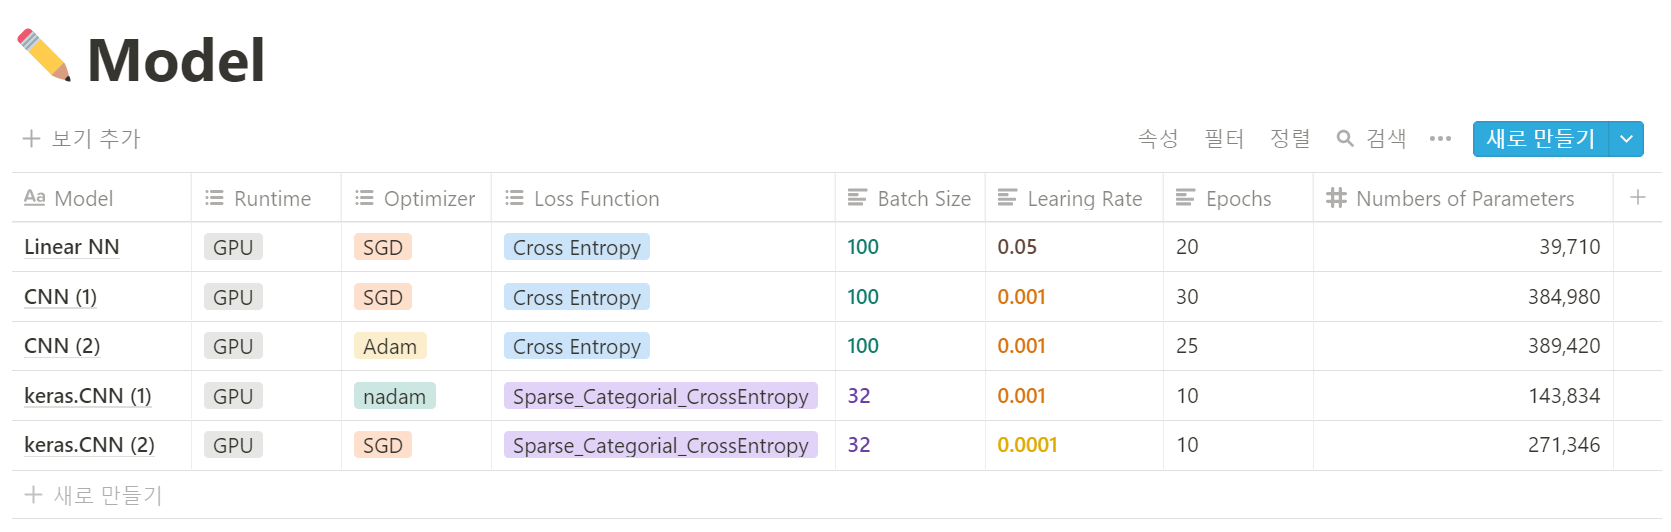

##**2.Performance**

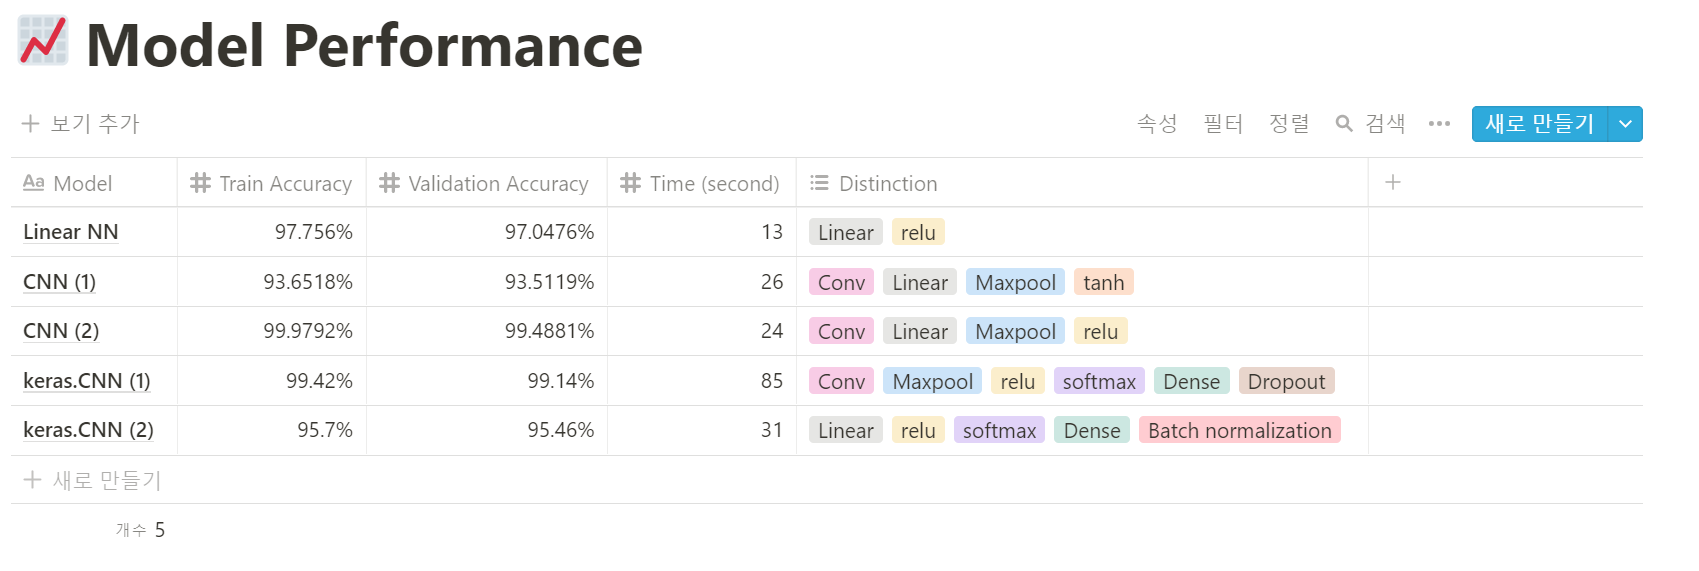